# Tensor Completion by Parallel Matrix Factorization via Tensor Train

----------------

Tensor Completion by Parallel Matrix Factorization via Tensor Train (Tmac-TT) is from:

> J. A. Bengua, H. N. Phien, H. D. Tuan, and M. N. Do.  Effi-cient tensor completion for color image and video recovery:Low-rank tensor train. IEEE Transactions on Image Processing, 26(5): 2466–2479, May 2017. [[**PDF**](https://arxiv.org/pdf/1606.01500.pdf)]

## Selected Images

We carry out our image inpainting experiments on the images of `Lena` and `Peppers`.

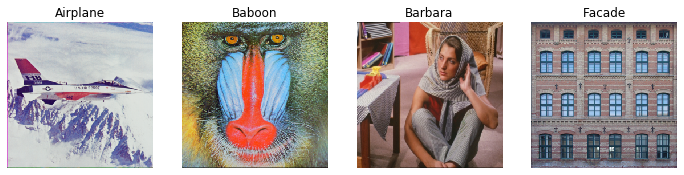

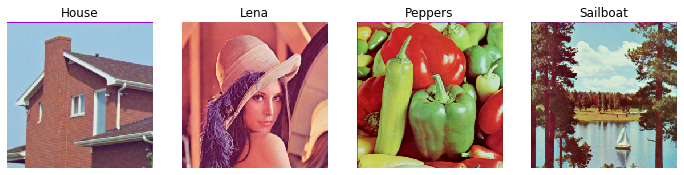

In [3]:
import numpy as np
import imageio
import matplotlib.pyplot as plt

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/airplane.bmp'))
plt.title('Airplane')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/baboon.bmp'))
plt.title('Baboon')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/barbara.bmp'))
plt.title('Barbara')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/facade.bmp'))
plt.title('Facade')
plt.axis('off')

plt.subplots(1, 4, figsize = (12, 20))
plt.subplot(1, 4, 1)
plt.imshow(imageio.imread('data/house.bmp'))
plt.title('House')
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(imageio.imread('data/lena.bmp'))
plt.title('Lena')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(imageio.imread('data/peppers.bmp'))
plt.title('Peppers')
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(imageio.imread('data/sailboat.bmp'))
plt.title('Sailboat')
plt.axis('off')

plt.show()

## Tmac-TT

### Preparation

We start by importing the necessary dependencies, and the following defined functions only make use of `numpy`.

In [4]:
import numpy as np
from numpy.linalg import inv as inv
from numpy.linalg import pinv as pinv
import numpy.linalg as ng

Functions for unfolding a tensor into a matrix (`ten2mat`) and folding a matrix into a tensor (`mat2ten`) according to a specific mode:

In [5]:
def ten2mat(tensor, mode):
    return np.reshape(np.moveaxis(tensor, mode, 0), (tensor.shape[mode], -1), order = 'F')

In [6]:
def mat2ten(mat, tensor_size, mode):
    index = list()
    index.append(mode)
    for i in range(tensor_size.shape[0]):
        if i != mode:
            index.append(i)
    return np.moveaxis(np.reshape(mat, list(tensor_size[index]), order = 'F'), 0, mode)

#### Ket augmentation

In [7]:
def KA(image, child):
    dim1, dim2, dim3 = image.shape
    dimn = np.int(np.log(dim1) / np.log(child) + np.log(dim2) / np.log(child))
    newdim = []
    for i in range(dimn):
        newdim.append(child)
    newdim.append(dim3)
    highordertensor = np.zeros(newdim)
    d = np.int(child ** 0.5)
    indmat = np.arange(0, child, 1).reshape([d, d], order = 'F').astype(int)
    newind = np.zeros((dim1, dim2, dimn)).astype(int)
    for i in range(dim1):
        for j in range(dim2):
            x = i
            y = j
            for k in range(dimn):
                indx = np.int(x % d)
                indy = np.int(y % d)
                newind[i, j, dimn - k - 1] = indmat[indx, indy]
                x = x // d
                y = y // d 
            indtuple = tuple(map(tuple, newind[i, j, :].reshape(len(newind[0,0,:]),1)))
            highordertensor[indtuple] = image[i, j, :]
    return highordertensor, newind

#### Inverse ket augmentation

In [8]:
def xind2mul(vec, child):
    newvec = np.zeros(len(vec))
    d = np.int(child ** 0.5)
    xind = np.zeros((d, d)).astype(int)
    for i in range(d):
        xind[:, i] = i
    xind = xind.reshape([child])
    for i in range(len(vec)):
        newvec[i] = xind[vec[i]]
    return newvec

def yind2mul(vec, child):
    newvec = np.zeros(len(vec))
    d = np.int(child ** 0.5)
    xind = np.zeros((d, d)).astype(int)
    for i in range(d):
        xind[i, :] = i
    xind = xind.reshape([child])
    for i in range(len(vec)):
        newvec[i] = xind[vec[i]]
    return newvec

def invKA(tensor, tind):
    child = tensor.shape[0]
    dim1, dim2, dimn = tind.shape
    d = np.int(child ** 0.5)
    weightd = np.ones(dimn)
    for i in range(dimn):
        weightd[i] = d ** (dimn - 1 - i)

    image = np.zeros((dim1, dim2, 3)).astype(int)
    for i in range(dim1):
        for j in range(dim2):
            newind = tind[i, j, :]
            x = np.int(np.matmul(xind2mul(newind, child), weightd))
            y = np.int(np.matmul(yind2mul(newind, child), weightd))
            indtuple = tuple(map(tuple, newind.reshape(len(newind),1)))
            image[x, y, :] = tensor[indtuple]
    return image

#### KA and Inverse KA test

9
(256, 256, 3)
(4, 4, 4, 4, 4, 4, 4, 4, 3)
(256, 256, 8)
(256, 256, 3)
<class 'numpy.ndarray'>


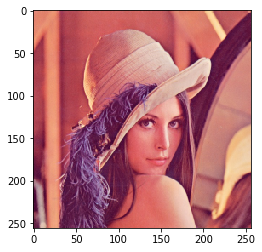

In [9]:
import imageio
from matplotlib import pyplot as plt

name0 = ["lena"]
name = ["lena_mar"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('data/{}.bmp'.format(name[0]))
highordertensor, tind = KA(image, 4)
print(highordertensor.ndim)
print(image.shape)
print(highordertensor.shape)
print(tind.shape)
image_rec = invKA(highordertensor, tind)
print(image_rec.shape)
print(type(image_rec))
plt.imshow(image_rec)

#### Multivariate rank generator

In [14]:
def SVD_MPS_Rank_Estimation(X,th):
    #Function to decompose a high-order rank tensor into an MPS
    N =  X.ndim
    RankX = np.zeros(N-1)
    sizX = X.shape
    T = X.reshape([sizX[0], np.prod(sizX[1:])]).copy()
    for k in range(N - 1):
#         print(T.shape)
        _ , S, V, chi = svd_RankEstimate(T,th) 
        T = np.matmul(S, V)
        intersz = np.append(np.array([chi]), sizX[k + 1: ])
        T = T.reshape(intersz).copy()
        if k < N-2:
            T = T.reshape([chi * sizX[k+1], np.prod(sizX[(k+2):])]).copy()        
        RankX[k] = chi
    return RankX

def svd_RankEstimate(T,th):
    U, S, V=np.linalg.svd(T, full_matrices = 0)
#     V=V.T
    chi = 0
    szS = len(S) 
    for k in range(szS):
        if S[k]/S[0] > th:
            chi = chi+1
    chi = max(chi,2)
    U = U[:,0:chi]
    S = np.diag(S[0:chi])
    V = V[0:chi,:]
#    print('The original rank is %d and truncated rank is %d'%(szS,chi))
    return U, S, V, chi

#### Multivariate rank generation test

In [15]:
import imageio

name0 = ["peppers"]
name = ["peppers_mar90"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('data/{}.bmp'.format(name[0]))
X, tind = KA(sparse_image, 4)
rank = SVD_MPS_Rank_Estimation(X,0.02)
rank

array([  4.,  16.,  64., 256., 179.,  48.,  12.,   3.])

#### Mode weight generator

In [16]:
def weightTC(dim):
    N = len(dim)
    weight = np.zeros(N-1)
    IL = dim[0]
    for k in range(N - 1):
        IR = np.prod(dim[k+1:])
        weight[k] = min(IL,IR)
        IL = IL * dim[k+1]
    weight = weight/(sum(weight))
    return weight

#### Mode weight generator test

In [17]:
a = np.ones((3,4,5,4))
lambda0 = [0.1, 0.2, 0.2, 0.4]
b = np.dot(a, lambda0)
b.shape

(3, 4, 5)

### Main function

Reshape the $256\times 256\times 3$ image data tensor to
- 1) 9th order tensor with size of $4\times 4\times 4\times 4\times 4\times 4\times 4\times 4\times 3$,
- 2) 5th order tensor with size of $16\times 16\times 16\times 16\times 3$.

We only use 9th order tensor in the following.

In [72]:
def Tmac_TT(dense_tensor, sparse_tensor, maxiter, th):
    """Main function of the Tmac-TT for 9th-order tensor."""
    
    dim = [4, 4, 4, 4, 4, 4, 4, 4, 3]
    weight = weightTC(dim)
    sparse_tensor_new, tind = KA(sparse_tensor, child = 4)
    dim0 = sparse_tensor_new.ndim
    tensor_hat_new = sparse_tensor_new.copy()
    binary_tensor = sparse_tensor_new.copy()
    binary_tensor[np.where(sparse_tensor_new != 0)] = 1
    X = np.random.rand(4, 4, 4, 4, 4, 4, 4, 4, 3, dim0 - 1)
    for k in range(dim0 - 1):
        X[:, :, :, :, :, :, :, :, :, k] = tensor_hat_new
    
    U_list = []
    V_list = []
    rank = SVD_MPS_Rank_Estimation(sparse_tensor_new, th)
    rank = rank.astype(int)
    for k in range(dim0 - 1):
        U_list.append(0.1 * np.random.rand(4 ** (k + 1), rank[k]))
        V_list.append(0.1 * np.random.rand(rank[k], 4 ** (8 - k - 1) * 3))
    for iters in range(maxiter):
        for k in range(dim0 - 1):
            unfold_var = X[:, :, :, :, :, :, :, :, :, k].reshape([4 ** (k + 1), 4 ** (8 - k - 1) * 3], order = 'F')
            U_list[k] = np.matmul(unfold_var, V_list[k].T)
            var = pinv(np.matmul(U_list[k].T, U_list[k]))
            V_list[k] = np.matmul(np.matmul(var, U_list[k].T), unfold_var)
            X[:, :, :, :, :, :, :, :, :, k] = np.matmul(U_list[k], V_list[k]).reshape(dim, order = 'F')
        tensor_hat_new = np.multiply(1 - binary_tensor, np.dot(X, weight)) + sparse_tensor_new
        for k in range(dim0 - 1):
            X[:, :, :, :, :, :, :, :, :, k] = tensor_hat_new.copy()
    tensor_hat = invKA(tensor_hat_new, tind)
    return tensor_hat

## Experiments on Color Images

In the following, we illustrate the performance of image inpainting tasks using Tmac-TT on some color images.

We set the missing patterns as

- missing at random (MAR), 
- row-wise missing at random (R-MAR),
- column-wise missing at random (C-MAR), 
- (row,column)-wise missing at random (RC-MAR),

and the missing rate as 30%,50%, and 70%. In particular, we carry out the experiment on each image at each specific missing rate for 50 times.

The recovery performance is measured by $$\text{RSE}=\frac{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{X}})-\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}{\|\mathcal{P}_{\Omega}^{\perp}(\boldsymbol{\mathcal{Y}})\|_{F}}\times 100.$$

### Evaluated on `lena` and `peppers`

Here, it is convenient to import the image under a certain missing pattern at the 50% missing rate. For example, on the image `Lena`, we could choose

- `lena_mar`
- `lena_rmar`
- `lena_cmar`
- `lena_rcmar`

#### Generate MAR

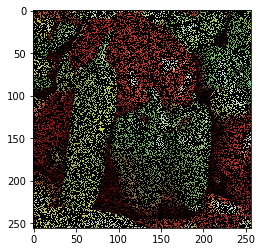

In [86]:
import imageio

name0 = ["peppers"]
name = ["peppers_mar"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
dim1, dim2, dim3 = image.shape
rate = 0.7
mask = np.round(np.random.rand(dim1, dim2) + 0.5 - rate)
for k in range(dim3):
    sparse_image[:, :, k] = np.multiply(image[:, :, k], mask) # Generate incomplete image
plt.imshow(sparse_image)

#### Standard test image

In [83]:
import imageio

name0 = ["lena"]
name = ["lena_rcmar"]
image = imageio.imread('data/{}.bmp'.format(name0[0]))
sparse_image = imageio.imread('data/{}.bmp'.format(name[0]))

In [84]:
import numpy as np
import imageio
import matplotlib.pyplot as plt
maxiter = 200
th = 0.2
image_hat = Tmac_TT(image, sparse_image, maxiter, th)
image_rec = np.round(image_hat).astype(int)
image_rec[np.where(image_rec > 255)] = 255
image_rec[np.where(image_rec < 0)] = 0
pos = np.where((image != 0) & (sparse_image == 0))
rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
imageio.imwrite('data/Tmac_TT_{}.jpg'.format(name[0]), np.uint8(image_rec))
print(100 * rse)

14.680183927400542


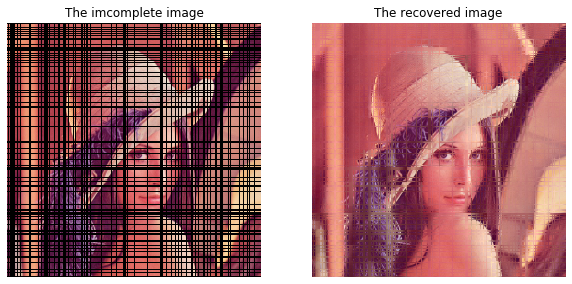

In [85]:
plt.subplots(1, 2, figsize=(10, 15))
plt.subplot(1, 2, 1)
plt.imshow(sparse_image)
plt.title('The imcomplete image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(image_rec)
plt.title('The recovered image')
plt.axis('off')
plt.show()

Table 1-1: **Experiment results** (RSE performance) of image inpainting for `lena` and `peppers` using Tmac-TT:

|  Images   |      MAR      |     R-MAR      |   C-MAR   |     RC-MAR     |
|:----------|--------------:|---------------:|----------:|---------------:|
| **lena**  |     8.46      |      12.11     |   14.11   |     14.68      |
|**peppers**|     9.76      |      17.45     |   17.62   |     18.48      |

- Parameter setting:

 - Carry out on 9th order tensor, 
 - For MAR missing pattern, `rank thresholding` = 0.1.
 - For MAR/R-MAR/C-MAR/RC-MAR missing pattern, `rank thresholding` = 0.2.

### Whole Performance

We choose the images of `lena` and `peppers` for evaluation.

#### MAR (Missing at random)

In [17]:
rank = 2
maxiter = 200
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask = np.round(np.random.rand(dim1, dim2) + 0.5 - rate)  # Generate a binary mask.
            sparse_image = image.copy()
            for k in range(dim3):
                sparse_image[:, :, k] = np.multiply(image[:, :, k], mask) # Generate incomplete image
            image_hat = Tmac_TT(image, sparse_image, rank, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [18]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[18.66472634 20.55470941 22.97355759]
 [24.87881667 27.47491399 30.97174285]]

[[0.12533718 0.10037215 0.09991401]
 [0.0922099  0.09164701 0.1760929 ]]



#### R-MAR (Row-wise missing at random)

In [19]:
rank = 2
maxiter = 200
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = Tmac_TT(image, sparse_image, rank, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [20]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[21.73275196 24.0775776  30.37267268]
 [30.12990531 33.22828959 39.12316032]]

[[0.63837866 1.30494938 3.75631651]
 [0.85901438 1.18355321 2.93316397]]



#### C-MAR (Column-wise missing at random)

In [21]:
rank = 2
maxiter = 200
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_column = np.round(np.random.rand(dim2) + 0.5 - rate)
            image0 = image.copy()
            for i in range(dim1):
                for j in range(dim3):
                    image0[i, :, j] = np.multiply(image[i, :, j], mask_column)
            sparse_image = image0.copy() # Generate incomplete image
            image_hat = Tmac_TT(image, sparse_image, rank, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [22]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[23.58196519 25.83216488 32.57491887]
 [30.85703622 34.33155976 39.06103811]]

[[0.6849108  0.93457751 3.32588818]
 [0.97686995 1.04306091 1.93152878]]



#### RC-MAR

In [25]:
rank = 2
maxiter = 200
im = ["lena", "peppers"]
result = np.zeros((len(im), 3, 50))
for ima in range(len(im)):
    image = imageio.imread('data/{}.bmp'.format(im[ima]))
    dim1, dim2, dim3 = image.shape
    for missing in range(result.shape[1]):
        for it in range(result.shape[2]):
            rate = 0.1 * (2 * missing + 3) # Set missing rate
            mask_row = np.round(np.random.rand(dim1) + 0.5 - (1 - np.sqrt(1 - rate)))
            mask_column = np.round(np.random.rand(dim2) + 0.5 - (1 - np.sqrt(1 - rate)))
            image0 = image.copy()
            for i in range(dim2):
                for j in range(dim3):
                    image0[:, i, j] = np.multiply(image[:, i, j], mask_row)
            sparse_image = image0.copy() # Generate incomplete image
            for i in range(dim1):
                for j in range(dim3):
                    sparse_image[i, :, j] = np.multiply(image0[i, :, j], mask_column)
            image_hat = Tmac_TT(image, sparse_image, rank, maxiter)
            image_rec = np.round(image_hat).astype(int)
            image_rec[np.where(image_rec > 255)] = 255
            image_rec[np.where(image_rec < 0)] = 0
            pos = np.where((image != 0) & (sparse_image == 0))
            rse = np.linalg.norm(image_rec[pos] - image[pos], 2) / np.linalg.norm(image[pos], 2)
            result[ima, missing, it] = rse
        print('Image: %s' % (im[ima]))
        print('Missing rate: {:.2}'.format(0.1 * (2 * missing + 3)))
        print()

Image: lena
Missing rate: 0.3

Image: lena
Missing rate: 0.5

Image: lena
Missing rate: 0.7

Image: peppers
Missing rate: 0.3

Image: peppers
Missing rate: 0.5

Image: peppers
Missing rate: 0.7



In [26]:
error = np.zeros((len(im), result.shape[1]))
std = np.zeros((len(im), result.shape[1]))
for ima in range(len(im)):
    for missing in range(result.shape[1]):
        error[ima, missing] = np.mean(100 * result[ima, missing, :])
        std[ima, missing] = np.std(100 * result[ima, missing, :])
print(error)
print()
print(std)
print()

[[22.00970321 23.56515603 26.10324363]
 [29.95752248 32.06583427 35.18260596]]

[[0.52336891 0.55709175 1.46363957]
 [0.69738115 0.60417465 0.81860875]]



Table 1-2: **Experiment results** (RSE performance) of image inpainting on two color images using Tmac-TT:

|    -      | Scenario  |      MAR       |     R-MAR      |      C-MAR     |     RC-MAR     |
|:----------|:----------|---------------:|---------------:|---------------:|---------------:|
|  **Lena** | **30%**   |18.66 $\pm$ 0.13|21.73 $\pm$ 0.64|23.58 $\pm$ 0.68|22.01 $\pm$ 0.52|
|       -   | **50%**   |20.55 $\pm$ 0.10|24.08 $\pm$ 1.30|25.83 $\pm$ 0.93|23.57 $\pm$ 0.56|
|       -   | **70%**   |22.97 $\pm$ 0.10|30.37 $\pm$ 3.76|32.57 $\pm$ 3.33|26.10 $\pm$ 1.46|
|**Peppers**| **30%**   |24.88 $\pm$ 0.13|30.13 $\pm$ 0.86|30.86 $\pm$ 0.98|29.96 $\pm$ 0.70|
|       -   | **50%**   |27.47 $\pm$ 0.09|33.23 $\pm$ 1.18|34.33 $\pm$ 1.04|32.07 $\pm$ 0.60|
|       -   | **70%**   |30.97 $\pm$ 0.18|39.12 $\pm$ 2.93|39.06 $\pm$ 1.93|35.18 $\pm$ 0.82|